# Gold Price Forecasting 
### A Time-Series Regression Project by Team 07 (IIT Jodhpur, MTech DE)

This project aims to predict future gold prices using historical data and machine learning techniques, focusing on real-time financial trends and practical forecasting.


##Install Python Libraries

In [1]:
!pip install xgboost --quiet
!pip install scikit-learn --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from datetime import timedelta
from IPython.display import display

## Reading the Dataset

In [3]:
df = pd.read_csv("XAU_30m_data.csv",delimiter=';',parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-06-11 07:00:00,384.0,384.3,383.8,384.3,12
1,2004-06-11 07:30:00,383.8,384.3,383.3,383.8,32
2,2004-06-11 08:00:00,383.8,384.3,383.5,383.5,28
3,2004-06-11 08:30:00,383.3,383.5,383.1,383.1,13
4,2004-06-11 09:00:00,383.1,384.1,382.8,383.0,24


## Data Pre-Processing

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d %H:%M')
df.set_index('Date', inplace=True)
df = df.sort_index()
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [5]:
daily_df = df['Close'].resample('D').last().dropna().to_frame()
daily_df.rename(columns={'Close': 'Price'}, inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2004-06-11 07:00:00,384.0,384.3,383.8,384.3,12
2004-06-11 07:30:00,383.8,384.3,383.3,383.8,32
2004-06-11 08:00:00,383.8,384.3,383.5,383.5,28
2004-06-11 08:30:00,383.3,383.5,383.1,383.1,13
2004-06-11 09:00:00,383.1,384.1,382.8,383.0,24


## Feature Engineering and Target Preparation

### Features Created:
- **MA_3, MA_7, MA_14**: Short and medium-term moving averages
- **Return_1**: Daily return (percentage change from previous day)
- **Volatility_7**: 7-day rolling standard deviation of prices (volatility)
- **Momentum_3**: Price momentum over 3 days
- **ROC_3**: Rate of change (3-day price percentage change)
- **RSI_14**: 14-day Relative Strength Index to measure overbought/oversold levels

In [6]:
daily_df['MA_3'] = daily_df['Price'].rolling(3).mean()
daily_df['MA_7'] = daily_df['Price'].rolling(7).mean()
daily_df['MA_14'] = daily_df['Price'].rolling(14).mean()
daily_df['Return_1'] = daily_df['Price'].pct_change()
daily_df['Volatility_7'] = daily_df['Price'].rolling(7).std()
daily_df['Momentum_3'] = daily_df['Price'] - daily_df['Price'].shift(3)
daily_df['ROC_3'] = daily_df['Price'].pct_change(periods=3)

In [7]:
delta = daily_df['Price'].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
daily_df['RSI_14'] = 100 - (100 / (1 + rs))

### Target Variable:
The next day's price (`Price` shifted by -1), which we aim to predict.

In [8]:
daily_df['Target'] = daily_df['Price'].shift(-1)
daily_df.dropna(inplace=True)

### Final Input Features for Model:

In [9]:
features = ['Price', 'MA_3', 'MA_7', 'MA_14', 'Return_1', 'Volatility_7',
            'Momentum_3', 'ROC_3', 'RSI_14']
X = daily_df[features]
y = daily_df['Target']

## Model Training


In [10]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
ridge = make_pipeline(StandardScaler(), Ridge(alpha=0.5))

rf.fit(X, y)
ridge.fit(X, y)

,steps,"[('standardscaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.5
,fit_intercept,True
,copy_X,True
,max_iter,None


In [11]:
pred_rf = rf.predict(X)
pred_ridge = ridge.predict(X)
y_pred = (pred_rf + pred_ridge) / 2
daily_df['Predicted_Price'] = y_pred

## Model Evaluation – Actual vs Predicted Prices

We evaluate our model using MAE (Mean Absolute Error) and RMSE (Root Mean Square Error).

In [12]:
mae = mean_absolute_error(daily_df['Target'], daily_df['Predicted_Price'])
rmse = np.sqrt(mean_squared_error(daily_df['Target'], daily_df['Predicted_Price']))

print(f" MAE (full): {mae:.2f}")
print(f" RMSE (full): {rmse:.2f}")

 MAE (full): 7.02
 RMSE (full): 10.57


## Recursive Multi-Day Price Forecasting (Next 10 Days)


In [13]:
# Copy latest dataset
future_df = daily_df.copy()

# Store predicted prices
future_preds = []

# Predict next 10 days recursively
for i in range(10):
    last_date = future_df.index[-1]
    next_date = last_date + timedelta(days=1)

    # Calculate features using latest data
    temp_df = future_df.copy()

    ma_3 = temp_df['Price'].iloc[-3:].mean()
    ma_7 = temp_df['Price'].iloc[-7:].mean()
    ma_14 = temp_df['Price'].iloc[-14:].mean()
    return_1 = (temp_df['Price'].iloc[-1] - temp_df['Price'].iloc[-2]) / temp_df['Price'].iloc[-2]
    volatility_7 = temp_df['Price'].iloc[-7:].std()
    momentum_3 = temp_df['Price'].iloc[-1] - temp_df['Price'].iloc[-4]
    roc_3 = (temp_df['Price'].iloc[-1] - temp_df['Price'].iloc[-4]) / temp_df['Price'].iloc[-4]

    # RSI
    delta = temp_df['Price'].diff()
    gain = delta.clip(lower=0).rolling(14).mean().iloc[-1]
    loss = -delta.clip(upper=0).rolling(14).mean().iloc[-1]
    rs = gain / loss if loss != 0 else 0
    rsi_14 = 100 - (100 / (1 + rs))

    # Build feature row
    feature_row = pd.DataFrame([{
        'Price': temp_df['Price'].iloc[-1],
        'MA_3': ma_3,
        'MA_7': ma_7,
        'MA_14': ma_14,
        'Return_1': return_1,
        'Volatility_7': volatility_7,
        'Momentum_3': momentum_3,
        'ROC_3': roc_3,
        'RSI_14': rsi_14
    }], index=[next_date])

    # Predict next day's price
    pred_rf = rf.predict(feature_row)[0]
    pred_ridge = ridge.predict(feature_row)[0]
    predicted_price = (pred_rf + pred_ridge) / 2

    # Append to DataFrame
    new_row = feature_row.copy()
    new_row['Price'] = predicted_price
    new_row['Target'] = None
    new_row['Predicted_Price'] = predicted_price
    future_df = pd.concat([future_df, new_row])
    future_preds.append((next_date, predicted_price))


C:\Users\home\AppData\Local\Temp\ipykernel_27368\237485730.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df = pd.concat([future_df, new_row])
C:\Users\home\AppData\Local\Temp\ipykernel_27368\237485730.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df = pd.concat([future_df, new_row])
C:\Users\home\AppData\Local\Temp\ipykernel_27368\237485730.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

In [14]:
# Convert to DataFrame
future_preds_df = pd.DataFrame(future_preds, columns=['Date', 'Predicted_Price'])
future_preds_df.set_index('Date', inplace=True)
print(" Next 10 Days Gold Price Predictions")
display(future_preds_df)


 Next 10 Days Gold Price Predictions


,Predicted_Price
Date,
2025-07-15,3347.033305
2025-07-16,3345.603801
2025-07-17,3338.103088
2025-07-18,3329.816133
2025-07-19,3336.244084
2025-07-20,3334.125485
2025-07-21,3335.855004
2025-07-22,3340.932112
2025-07-23,3340.972015


## Plot Actual vs Predicted Prices along with 10 days forecast

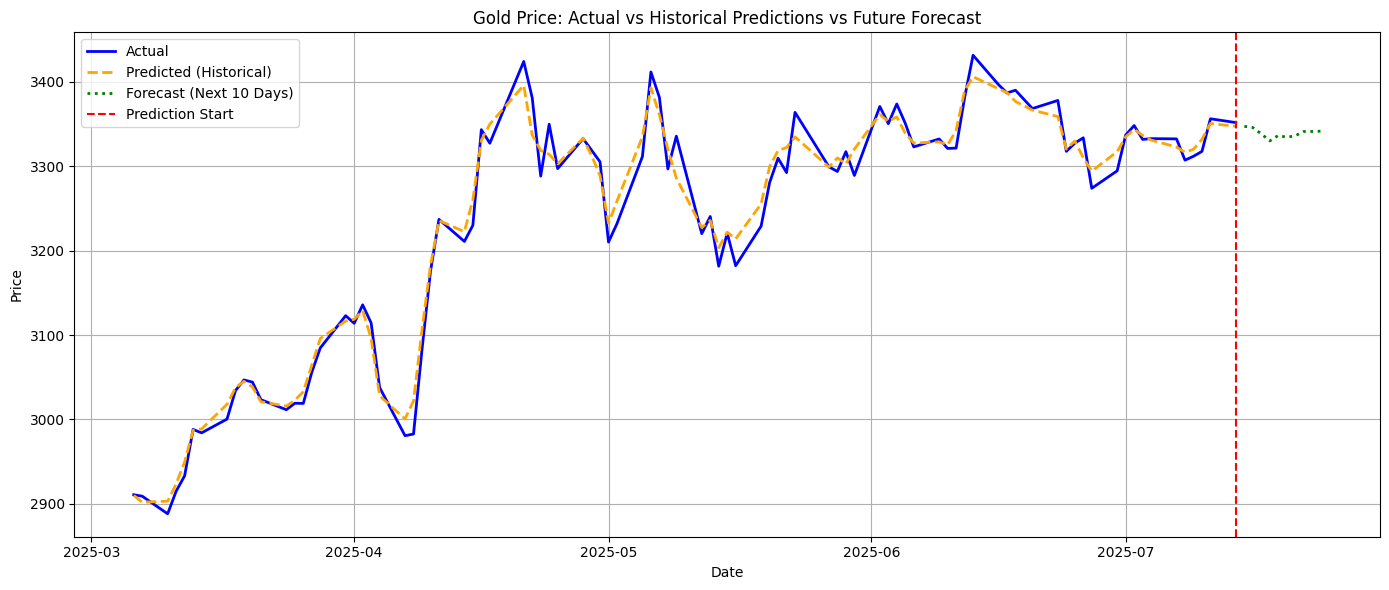

In [15]:
# Combine actual + predicted (past) + future forecast

# past_actual = daily_df[['Price']]  # No slicing shows data from start date
# past_predicted = daily_df[['Predicted_Price']].rename(columns={'Predicted_Price': 'Price'})  # No slicing shows data from start date
# future_forecast = future_preds_df.rename(columns={'Predicted_Price': 'Price'})

past_actual = daily_df[['Price']].iloc[-90:]  # for slicing to 90 days
past_predicted = daily_df[['Predicted_Price']].iloc[-90:].rename(columns={'Predicted_Price': 'Price'}) # for slicing to 90 days
future_forecast = future_preds_df.rename(columns={'Predicted_Price': 'Price'})

# Plot
plt.figure(figsize=(14,6))
plt.plot(past_actual.index, past_actual['Price'], label="Actual", color='blue', linewidth=2)
plt.plot(past_predicted.index, past_predicted['Price'], label="Predicted (Historical)", color='orange', linestyle='--', linewidth=2)
plt.plot(future_forecast.index, future_forecast['Price'], label="Forecast (Next 10 Days)", color='green', linestyle=':', linewidth=2)

# Mark prediction start
plt.axvline(daily_df.index[-1], color='red', linestyle='--', label="Prediction Start")

plt.title("Gold Price: Actual vs Historical Predictions vs Future Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Model Error Analysis – Distribution of % Error

In [16]:
# Create comparison DataFrame
comparison_df = daily_df[['Price', 'Predicted_Price']].copy()
comparison_df['Absolute_Error'] = (comparison_df['Price'] - comparison_df['Predicted_Price']).abs()
comparison_df['% Error'] = (comparison_df['Absolute_Error'] / comparison_df['Price']) * 100

# Round values for readability
comparison_df = comparison_df.round(2)

def highlight_error(val):
    color = 'red' if val > 1 else ''
    return f'color: {color}'

# Apply style to % Error column
styled_df = comparison_df.tail(30).style.map(highlight_error, subset=['% Error'])

display(styled_df)

,Price,Predicted_Price,Absolute_Error,% Error
Date,,,,
2025-06-02 00:00:00,3370.600000,3361.080000,9.520000,0.280000
2025-06-03 00:00:00,3350.200000,3352.740000,2.540000,0.080000
2025-06-04 00:00:00,3373.500000,3358.310000,15.190000,0.450000
2025-06-05 00:00:00,3350.700000,3338.840000,11.860000,0.350000
2025-06-06 00:00:00,3322.700000,3327.300000,4.600000,0.140000
2025-06-09 00:00:00,3332.100000,3328.620000,3.480000,0.100000
2025-06-10 00:00:00,3320.900000,3325.080000,4.180000,0.130000
2025-06-11 00:00:00,3321.300000,3342.210000,20.910000,0.630000
2025-06-12 00:00:00,3380.900000,3389.260000,8.360000,0.250000


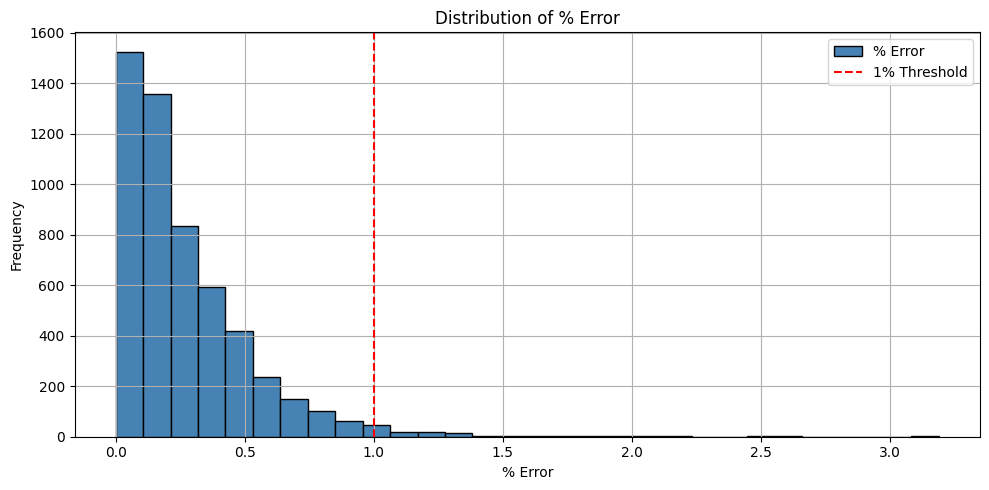

In [17]:
comparison_df['% Error'].plot(kind='hist', bins=30, color='steelblue', edgecolor='black', figsize=(10,5), title="Distribution of % Error")
plt.axvline(1, linestyle='--', color='red', label="1% Threshold")
plt.xlabel("% Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import joblib

# Save Random Forest model
joblib.dump(rf, 'rf_model.pkl')

# Save Ridge pipeline model (with scaler)
joblib.dump(ridge, 'ridge_model.pkl')


['ridge_model.pkl']

In [20]:
# Payload Data
latest_row = daily_df[features].iloc[-1].round(2).tolist()
print(latest_row)

[3351.5, 3341.63, 3329.74, 3325.23, -0.0, 19.04, 39.9, 0.01, 56.92]
